In [1]:
import torch
import torch.nn as nn
import numpy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
# select device
use_gpu = True
device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"

In [3]:

def get_data(n=500, sigma=0, min_weight=45, max_weight=150, min_height=1.3, max_height=2):
    """
    It is a function that gives you a tensor with the size, weight and imc of a person.

    args:
        n: number of tuples that you want
        sigma: the standar variation of the values
    """
    weight = torch.rand(n) * (max_weight - min_weight) + min_weight
    height = torch.rand(n) * (max_height - min_height ) + min_height
    imc = weight / torch.pow(height,2)

    noise_weight = torch.normal(torch.zeros_like(weight), torch.ones_like(weight)*sigma)
    noise_height = torch.normal(torch.zeros_like(weight), torch.ones_like(weight)*sigma * 0.05)
    noise_imc = torch.normal(torch.zeros_like(weight), torch.ones_like(weight)*sigma)
    
    height = torch.clamp(height + noise_height, min=1.2)

    return weight+noise_weight,height,imc+noise_imc


class Persons_Dataset(Dataset):
    
    def __init__(self, weight, height, imc, device):
        super().__init__()
        self.device = device
        self.x = torch.stack([weight, height], dim=1).to(device)
        self.y = imc.unsqueeze(1).to(device)

    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
weight, height, imc = get_data(50000)

train_dataset = Persons_Dataset(weight,height,imc,device)



i will split the datasets in 3

In [4]:
def split_dataset(dataset, split_share):
    mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
    indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
    indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]


    first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
    second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

    return first_subset, second_subset
def split_datasets(train_dataset, test_dataset_share=0.3,val_dataset_share=0.2):
    """
    This function it's used for split a dataset in three
    args:
        train_dataset: the initial dataset
        test_dataset_share: the percentage of data that will have the test_datset
        val_dataset_share: the percentage of data that will have the val_dataset
    """

    first_subset, second_subset = split_dataset(train_dataset,test_dataset_share+val_dataset_share)
    second_subset, thrid_subset = split_dataset(second_subset,val_dataset_share/(test_dataset_share+val_dataset_share))
    return first_subset, second_subset, thrid_subset

train_dataset, test_dataset, val_dataset = split_datasets(train_dataset)



In [5]:
class Early_Stop():
  def __init__(self, patience=5, delta=0):
    self.patience = patience
    self.delta = delta
    self.best_val_loss = None
    self.no_val_improvement_times = 0
    self.stop = False

  def check_stop(self, val_loss):
    if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
      self.best_val_loss = val_loss
      self.no_val_improvement_times = 0
    else:
      self.no_val_improvement_times += 1
      self.stop = self.no_val_improvement_times >= self.patience
      
def learning_loop_for_regression_with_early_stopping(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, early_stop):
    epoch_loss_list = []
    val_loss_list = []

    opt = optimizer

    with tqdm(range(epochs), desc="epoch:") as pbar:
        for epoch in pbar:
            model.train()
            steps_loss_list = []

            for x_true, y_true in train_dataloader:
                y_pred = model(x_true)
                opt.zero_grad()
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                steps_loss_list.append(loss.item())
                opt.step()

            train_loss = sum(steps_loss_list)/len(steps_loss_list)
            epoch_loss_list.append(train_loss)

            # Validación solo cada `validation_freq` epochs
            if epoch % validation_freq == 0:
                model.eval()
                val_step_loss_list = []
                with torch.no_grad():
                    for x_val_true, y_val_true in val_dataloader:
                        y_val_pred = model(x_val_true)
                        loss_val = loss_fn(y_val_pred, y_val_true)
                        val_step_loss_list.append(loss_val.item())

                val_loss = sum(val_step_loss_list)/len(val_step_loss_list)
                val_loss_list.append(val_loss)
                early_stop.check_stop(val_loss)
                if early_stop.stop:
                    pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")
                    print("Early Stop.")
                    break
            else:
                val_loss = val_loss_list[-1] if val_loss_list else None

            # Actualizamos tqdm con train y val loss (val_loss puede ser None)
            postfix = {"train_loss": f"{train_loss:.4f}"}
            if val_loss is not None:
                postfix["val_loss"] = f"{val_loss:.4f}"
            pbar.set_postfix(postfix)

    return model, epoch_loss_list, val_loss_list



    

Número de parámetros 19073


epoch::   6%|▌         | 60/1001 [00:37<09:43,  1.61it/s, train_loss=0.8416, val_loss=1.2624]

Early Stop.


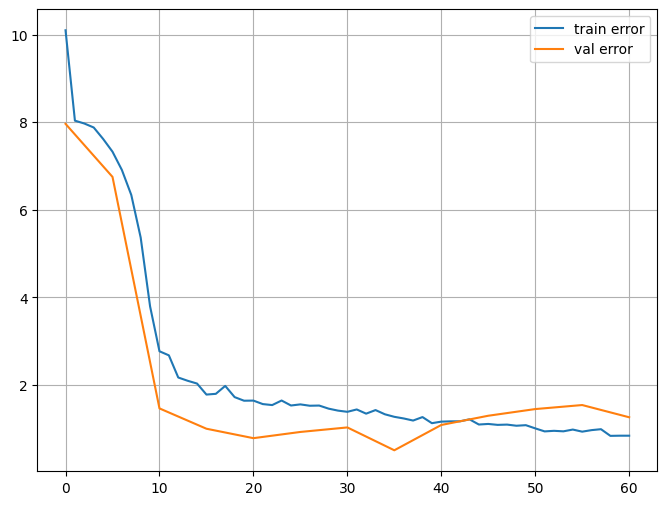

In [11]:
batch_size = 128
learning_rate = 8e-4
epochs = 1001
loss_fn = torch.nn.L1Loss()
validation_freq = 5
patience = 5
delta = 0.01

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(2,128),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(0.1),
    nn.Linear(128,64),
    torch.nn.LeakyReLU(),
    nn.Linear(64,64),
    torch.nn.LeakyReLU(),
    nn.Linear(64,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32,1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stop = Early_Stop(patience = patience,
                        delta = delta)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list = learning_loop_for_regression_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq,
    early_stop = early_stop
    )

plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), train_loss_list, label="train error")
plt.plot(range(0,len(train_loss_list),validation_freq), val_loss_list, label="val error")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()
model(torch.tensor([85,1.72]).to(device))

tensor([27.3793], device='cuda:0', grad_fn=<ViewBackward0>)